In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.base.model import GenericLikelihoodModel

(1000,)
12.500064456352522


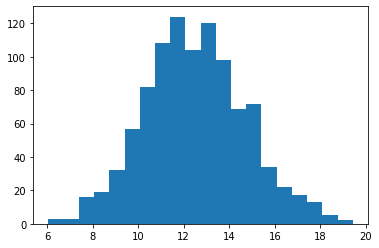

In [2]:
def gen_data(values):
    nobs = 1000
    
    #parameters
    
    
    min_bids =3
    max_bids =3
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i = bids_i.max(axis=1)
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids,bidders,nobs

mu = 10
sigma = 3
values_distr =stats.norm(loc=mu, scale=sigma)
bids,i,nobs = gen_data(values_distr)
print(bids.shape)
print(bids[i == 3].mean())



In [3]:
def inverse_order(cdf,i):
    """invert the order statistic for a given distribution
    function"""
    i = np.array(i)
    order_cdf = lambda x : i*cdf(x)*(1-cdf(x))**(i-1) #second highest order statistic
    return order_cdf


#parameters
mu = 10
sigma = 3
cdf = lambda x: stats.norm(loc=mu, scale=sigma).cdf(x)
order_cdf1 = inverse_order(cdf,[3,4])
print(order_cdf1([14,14]))

[0.02268197 0.00275847]


In [4]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.norm, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglike(self, params):
        bids = self.exog.transpose()
        i = self.exog[:,0]
        cdf = lambda x : self.values_distr.cdf(x,loc=params[0],scale=max(params[1],1e-5))
        order_cdf = lambda x : i*cdf(x)*(1-cdf(x))**(i-1) #second highest order statistic
        return np.log(order_cdf(bids)).sum()
    
mu = 10
sigma = 3
yn,xn,nobs = gen_data(stats.norm(loc=mu, scale=sigma))
model = Auction(yn,xn)
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -810.93
Model:                        Auction   AIC:                             1624.
Method:            Maximum Likelihood   BIC:                             1629.
Date:                Thu, 19 Nov 2020                                         
Time:                        16:35:49                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9104    285.755      0.017      0.986    -555.158     564.979
par0           4.4353    663.424      0.007      0.995   -1295.851    1304.722
==============================================================================
"""

In [ ]:
plt.hist(yn,bins=20)
plt.
plt.show()